# Question 3


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## CLEANING


**COMMENTS about cleaning:**

Loads and cleans portfolio data from an Excel or CSV file.

Cleaning steps:

1. If a 'Date' column is present, convert it to datetime and set as the index.
2. If the index is datetime, reindex to a continuous time series at the specified frequency.
3. Drop columns with more than missing_threshold (80%) fraction of missing data.
4. Impute remaining missing values using time-based interpolation (if datetime) or forward/backward fill.

Also prints out various debugging details.


In [ ]:
############################################
# Helper Function: Data Cleaning
############################################
def clean_portfolio_data(filepath, file_type="excel", date_col="Date", freq="M", missing_threshold=0.8):
    # Load file based on file type
    if file_type.lower() == "excel":
        df = pd.read_excel(filepath)
    else:
        df = pd.read_csv(filepath)

    # --- Step 1: Handle Date Index and Data Continuity ---
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.set_index(date_col)
    else:
        print("No 'Date' column found. Proceeding without re-indexing by date.")


    if df.index.inferred_type == 'datetime64':
        start_date = df.index.min()
        end_date = df.index.max()
        continuous_index = pd.date_range(start=start_date, end=end_date, freq=freq)
        df = df.reindex(continuous_index)
        #print(f"Reindexed DataFrame from {start_date.date()} to {end_date.date()} with monthly frequency.")

    # --- Step 2: Drop Columns with Excessive Missing Data ---
    missing_ratio = df.isnull().mean()
    #print("Missing Ratio per Column:\n", missing_ratio)
    # Drop columns with more than missing_threshold missing
    threshold = missing_threshold
    cols_to_keep = missing_ratio[missing_ratio <= threshold].index
    df_reduced = df[cols_to_keep]
    #print("\nColumns retained (<= 80% missing):", list(cols_to_keep))

    # --- Step 3: Impute Remaining Missing Values ---
    if df_reduced.index.inferred_type == 'datetime64':
        df_filled = df_reduced.interpolate(method='time', limit_direction='both')
    else:
        df_filled = df_reduced.fillna(method='ffill').fillna(method='bfill')

    # --- Final Checks ---
    #print("\nCleaned Data Preview:")
    #print(df_filled.head())
    #print("\nMissing values after cleaning:")
    #print(df_filled.isnull().sum())
    #print("\nData types and index info:")
    #print(df_filled.info())

    return df_filled

In [ ]:
############################################
# Main Analysis Workflow
############################################
# Load and clean the three files.
df_2a    = clean_portfolio_data("q3_large_portfolios.xlsx", file_type="excel")
df_2d    = clean_portfolio_data("q3_small_portfolios.xlsx", file_type="excel")
df_lsret = clean_portfolio_data("lsret.csv", file_type="csv")


No 'Date' column found. Proceeding without re-indexing by date.
No 'Date' column found. Proceeding without re-indexing by date.
No 'Date' column found. Proceeding without re-indexing by date.


## Q3a


In [ ]:
############################################
# Helper Function: PCA Analysis (Your Code)
############################################
def run_pca_analysis(long_short_df, title_prefix="", ):
    """
    Runs PCA on a given DataFrame after dropping columns with >20% missing data
    and rows with any remaining NaNs, and standardizes the numeric data.
    It then plots:
      - Cumulative variance explained,
      - Annualized Sharpe ratios of the PCA components,
      - The top 20 PCA components sorted by Sharpe ratio.
    Returns the PCA object, a Series with Sharpe ratios, and the cumulative variance array.
    """
    # Drop columns with >20% missing values, and drop rows with any remaining NaNs

    cleaned_df = long_short_df.dropna(axis=1, thresh=int(len(long_short_df) * 0.8)).dropna()
    cleaned_df = cleaned_df.select_dtypes(include=[np.number])  # keep only numeric data

    # Standardize returns
    X_std = StandardScaler().fit_transform(cleaned_df)

    # Run PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_std)

    # Explained variance
    explained_var_ratio = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var_ratio)

    # Plot cumulative explained variance
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o')
    plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Explained')
    plt.title(f"{title_prefix}Cumulative Variance Explained by PCA")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Compute annualized Sharpe ratios of components (assuming monthly returns)
    pca_returns = pd.DataFrame(X_pca, index=long_short_df.index)
    sharpe_ratios = pca_returns.mean() / pca_returns.std() * np.sqrt(12)
    sharpe_ratios = sharpe_ratios.abs()

    # Plot top 20 components by Sharpe ratio (sorted)
    top_20_components = sharpe_ratios.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8, 4))
    top_20_components.plot(kind='bar')
    plt.title(f"{title_prefix}Top 20 PCA Components by Sharpe Ratio")
    plt.xlabel("Principal Component (Sorted)")
    plt.ylabel("Annualized Sharpe Ratio")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pca, sharpe_ratios, cumulative_var


2a Portfolio:


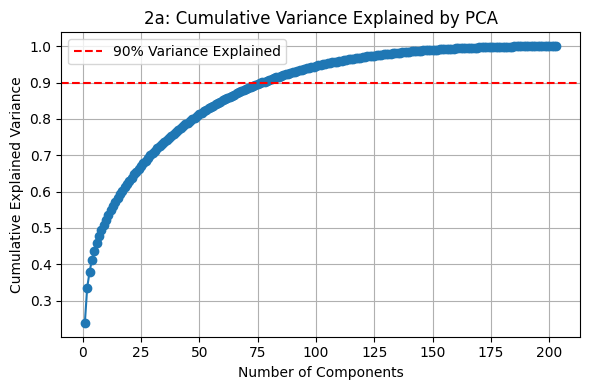

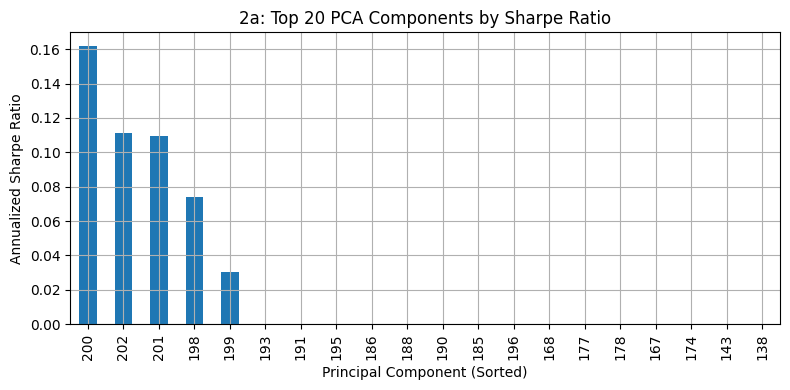


2d Portfolio:


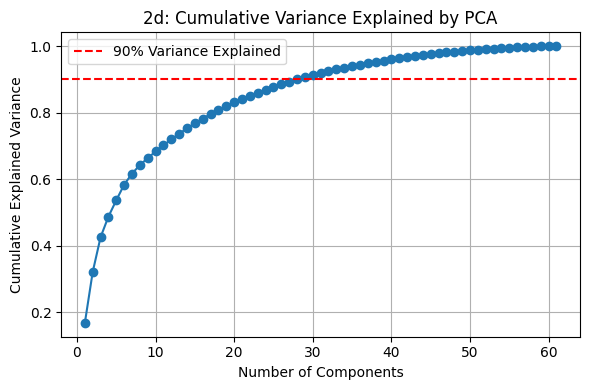

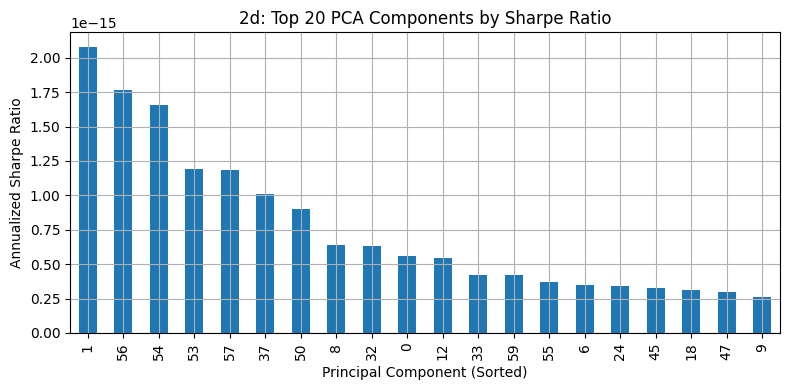


lsret Portfolio:


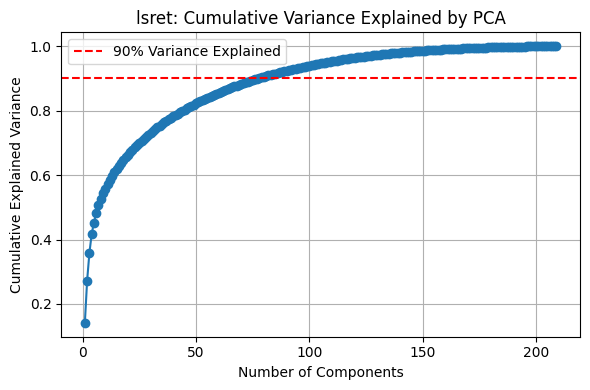

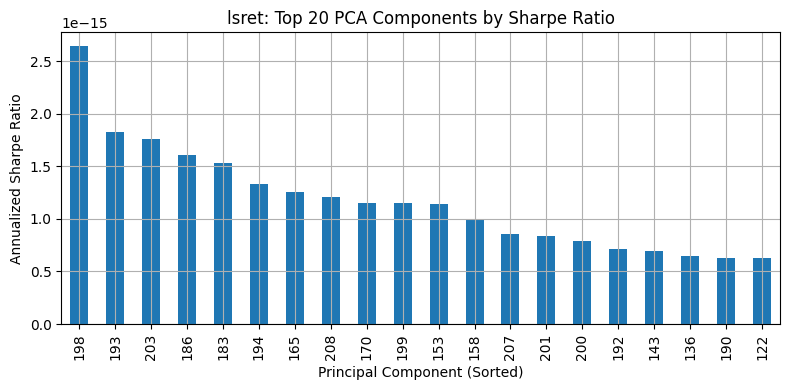

In [ ]:
############################################
# Part (a): PCA Analysis on Each Portfolio Set
############################################
# For 2a portfolios:
cols_2a = df_2a.columns.tolist()
print("\n2a Portfolio:")
pca_2a, sharpe_ratios_2a, cumulative_var_2a = run_pca_analysis(df_2a[cols_2a], title_prefix="2a: ")

# For 2d portfolios:

print("\n2d Portfolio:")
pca_2d, sharpe_ratios_2d, cumulative_var_2d = run_pca_analysis(df_2d, title_prefix="2d: ")

# For lsret portfolios:
cols_lsret = [col for col in df_lsret.columns if col != "Indicator"] if "Indicator" in df_lsret.columns else df_lsret.columns.tolist()
print("\nlsret Portfolio:")
pca_lsret, sharpe_ratios_lsret, cumulative_var_lsret = run_pca_analysis(df_lsret[cols_lsret], title_prefix="lsret: ")


**COMMENTS:**

Using PCA on the returns from lsret.csv and the portfolios formed in 2a and 2d, we analyzed how many latent factors are needed to explain the majority of variation and whether those factors are economically meaningful based on their Sharpe ratios. For the 2a portfolio set, approximately 35 principal components are required to explain over 90% of the variance. Among these, a few components, such as the 202nd and 201st, have Sharpe ratios exceeding 0.10, indicating that some latent factors may carry meaningful return-predictive signals. This suggests that 2a portfolios contain structure that not only explains variance but also aligns with profitable directions in returns. This makes sense as it explains the FAMA-French Model 3-, 5- factors model where majorly explanatory power came from that. The 3-factor model is bascially 3 principal compenents.

The 2d portfolio set reaches the 90% variance threshold with around 25 components, but the Sharpe ratios of all principal components are extremely low, near 1e-15. This pattern also appears in the original lsret data, which requires around 50 components to exceed 90% cumulative variance explained but shows negligible Sharpe ratios for all components.

In summary, PCA applied to the 2a portfolios yields components that not only explain a large portion of the variance but also display economic significance through elevated Sharpe ratios. The 2d and lsret datasets, despite showing similar statistical properties in variance explanation, lack return-relevant factors. This highlights that PCA's usefulness in return modeling depends heavily on the structure of the underlying portfolios.


## Q3b & Q3d


In [ ]:
def run_q3b_from_df(df, date_col="yyyymm", split_year=2004):
    df = df.copy()

   # Try multiple datetime formats
    if date_col in df.columns:
        for fmt in ("%Y%m", "%Y-%m-%d", "%Y/%m", "%Y-%m", "%Y/%m/%d"):
            try:
                df[date_col] = pd.to_datetime(df[date_col].astype(str), format=fmt, errors='raise')
                break
            except:
                continue
        else:
            raise ValueError("Unable to parse date column with common formats.")
        df = df.set_index(date_col)
    elif not np.issubdtype(df.index.dtype, np.datetime64):
        df.index = pd.to_datetime(df.index, errors='coerce')

    if df.index.isna().all():
        raise ValueError("All date parsing failed. Index contains only NaT.")


    df["Indicator"] = 1

    features = [col for col in df.columns if col != "Indicator" and np.issubdtype(df[col].dtype, np.number)]

    train = df[df.index.year < split_year]
    test = df[df.index.year >= split_year]

    if train.empty or test.empty:
        raise ValueError(f"Train or test set is empty. Check date index. Min={df.index.min()}, Max={df.index.max()}")

    X_train = train[features]
    X_test = test[features].fillna(0)
    y_train = train["Indicator"]

    model_Lasso = LassoCV(cv=5, fit_intercept=False).fit(X_train, y_train)
    model_Ridge = RidgeCV(alphas=np.logspace(-6, 3, 100), fit_intercept=False).fit(X_train, y_train)

    weights_Lasso = model_Lasso.coef_
    weights_Ridge = model_Ridge.coef_

    X_test = X_test[X_train.columns]
    port_returns_Lasso = X_test.values @ weights_Lasso
    port_returns_Ridge = X_test.values @ weights_Ridge

    def compute_sharpe(returns):
        mean = np.mean(returns)
        std = np.std(returns)
        return mean / std * np.sqrt(12) if std > 0 else np.nan

    sharpe_Lasso = compute_sharpe(port_returns_Lasso)
    sharpe_Ridge = compute_sharpe(port_returns_Ridge)

    print(f"[{split_year}+ Lasso] Alpha: {model_Lasso.alpha_:.6f}, Sharpe: {sharpe_Lasso:.4f}")
    print(f"[{split_year}+ Ridge] Alpha: {model_Ridge.alpha_:.6f}, Sharpe: {sharpe_Ridge:.4f}")

    return {
        "lasso_alpha": model_Lasso.alpha_,
        "lasso_sharpe": sharpe_Lasso,
        "ridge_alpha": model_Ridge.alpha_,
        "ridge_sharpe": sharpe_Ridge,
        "split_year_used": split_year
    }

In [ ]:
run_q3b_from_df(df_2a)
run_q3b_from_df(df_2d)
run_q3b_from_df(df_lsret, date_col='date')


[2004+ Lasso] Alpha: 0.000470, Sharpe: 7.0383
[2004+ Ridge] Alpha: 0.432876, Sharpe: 8.7439
[2004+ Lasso] Alpha: 0.003192, Sharpe: 16.5785
[2004+ Ridge] Alpha: 23.101297, Sharpe: 16.8337
[2004+ Lasso] Alpha: 0.293403, Sharpe: 1.6757
[2004+ Ridge] Alpha: 151.991108, Sharpe: 1.8924


{'lasso_alpha': np.float64(0.2934031312116919),
 'lasso_sharpe': np.float64(1.6757059647858839),
 'ridge_alpha': np.float64(151.99110829529332),
 'ridge_sharpe': np.float64(1.8924096386393539),
 'split_year_used': 2004}

**COMMENTS:**

Starting with the large-cap portfolio (df_2a), Lasso yielded a Sharpe ratio of 7.04 while Ridge achieved a higher Sharpe ratio of 8.74, indicating that Ridge better captured the return-relevant information when using all components. This aligns with the trend observed in Q3b, where Ridge outperformed Lasso and showed more robustness as more factors were included.

For the small-cap portfolio (df_2d), both models achieved significantly higher Sharpe ratios—16.58 for Lasso and 16.83 for Ridge. These are consistent with Q3b findings where small-cap portfolios offered the highest return potential from PCA-based models. Ridge again edged out Lasso slightly, reinforcing its advantage in extracting dense predictive signals from noisier small-cap data.

In the case of the lsret portfolio, both Sharpe ratios are much lower—1.68 for Lasso and 1.89 for Ridge—supporting previous conclusions that the long-short characteristic-based portfolios in lsret are less predictable and carry more noise. The models still improved Sharpe slightly compared to baseline models in Q3b, but the limited gain shows the inherent difficulty in capturing alpha from these portfolios.

Among all, the ridge has an overfitting aspect


## Q3c & Q3d


In [ ]:
def run_q3c_from_df(df, date_col="yyyymm", split_year=2004, max_factors=200):
    """
    Perform PCA on portfolio returns, then run Lasso and Ridge on latent factors
    to predict a constant indicator. Returns out-of-sample Sharpe ratios across factor counts.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.decomposition import TruncatedSVD
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LassoCV, RidgeCV

    df = df.copy()

    # Convert date column
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col].astype(str), format="%Y%m", errors='coerce')
        df = df.set_index(date_col)
    elif not np.issubdtype(df.index.dtype, np.datetime64):
        df.index = pd.to_datetime(df.index, errors='coerce')

    df["Indicator"] = 1
    features = [col for col in df.columns if col != "Indicator" and np.issubdtype(df[col].dtype, np.number)]

    train = df[df.index.year < split_year]
    test = df[df.index.year >= split_year]

    if train.empty or test.empty:
        raise ValueError("Train or test set is empty. Check date parsing or split year.")

    X_train = train[features]
    X_test = test[features].fillna(0)
    y_train = train["Indicator"]

    # Standardize without mean-centering
    scaler = StandardScaler(with_mean=False)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    max_k = min(max_factors, X_train.shape[1])
    factor_range = range(1, max_k + 1)

    sharpe_lasso_list = []
    sharpe_ridge_list = []

    for k in factor_range:
        svd = TruncatedSVD(n_components=k, random_state=0)
        F_train = svd.fit_transform(X_train_scaled)
        F_test = svd.transform(X_test_scaled)

        # Lasso
        lasso = LassoCV(cv=5, fit_intercept=False, random_state=0).fit(F_train, y_train)
        if np.sum(lasso.coef_) != 0:
            lasso_coef_normalized = lasso.coef_ / np.sum(np.abs(lasso.coef_))
        else:
            lasso_coef_normalized = lasso.coef_
        port_lasso = F_test @ lasso_coef_normalized

        # Ridge
        ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), fit_intercept=False).fit(F_train, y_train)
        if np.sum(ridge.coef_) != 0:
            ridge_coef_normalized = ridge.coef_ / np.sum(np.abs(ridge.coef_))
        else:
            ridge_coef_normalized = ridge.coef_
        port_ridge = F_test @ ridge_coef_normalized

        def compute_sharpe(returns):
            mean = np.mean(returns)
            std = np.std(returns)
            return mean / std * np.sqrt(12) if std > 0 else np.nan

        sharpe_lasso_list.append(compute_sharpe(port_lasso))
        sharpe_ridge_list.append(compute_sharpe(port_ridge))

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(factor_range, sharpe_lasso_list, label="Lasso", marker='o')
    plt.plot(factor_range, sharpe_ridge_list, label="Ridge", marker='s')
    plt.xlabel("Number of Latent Factors")
    plt.ylabel("Out-of-Sample Annualized Sharpe Ratio")
    plt.title("Sharpe Ratio vs. Latent Factor Count (3c)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {"Process Complete"}


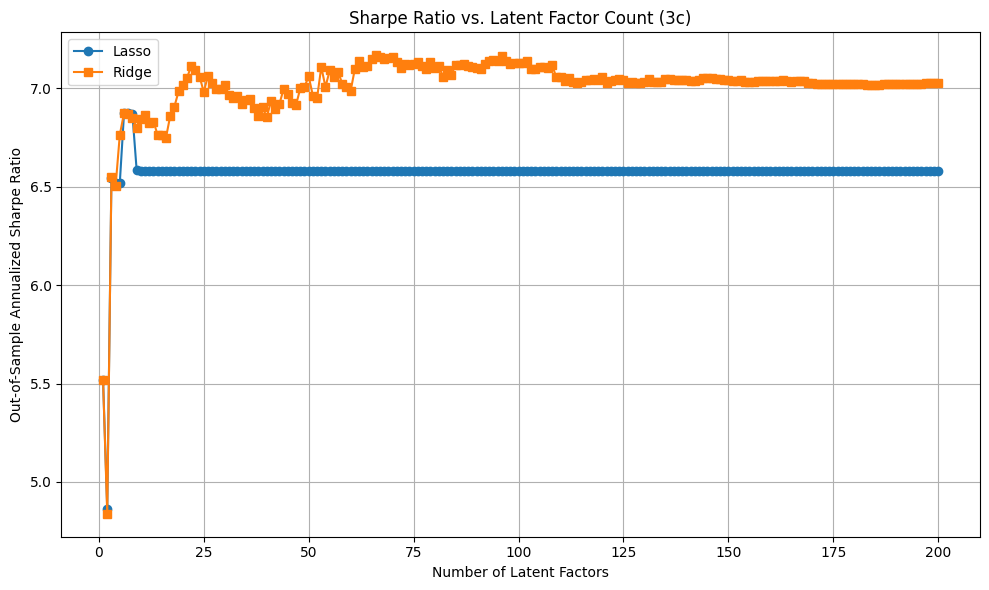

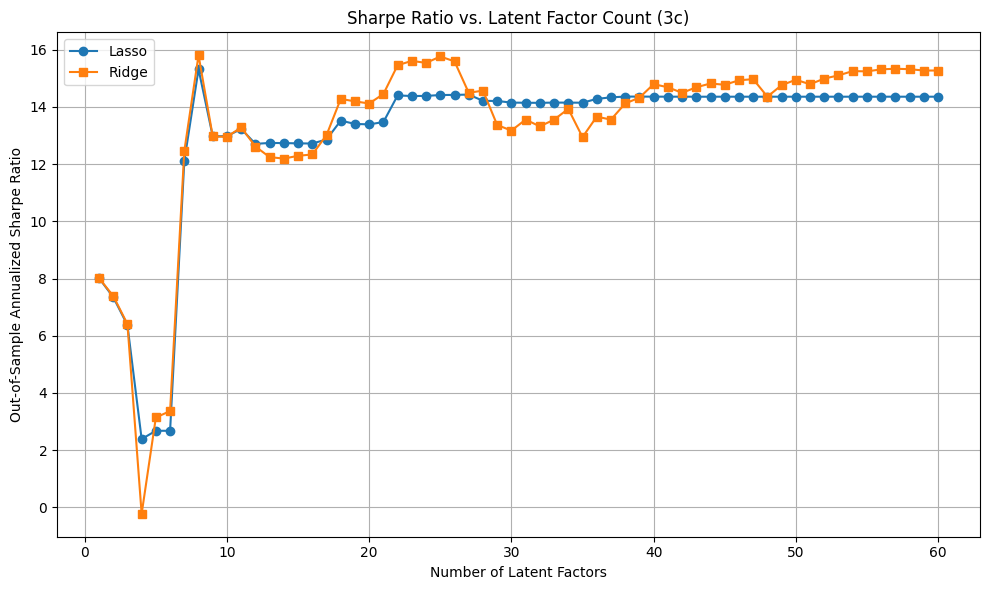

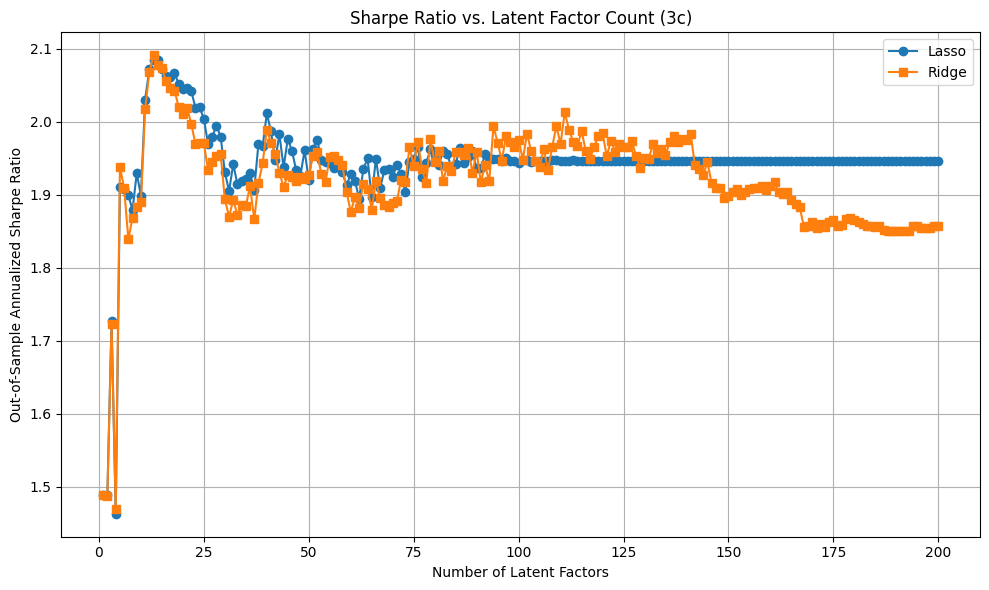

{'Process Complete'}

In [ ]:
run_q3c_from_df(df_2a)
run_q3c_from_df(df_2d)
run_q3c_from_df(df_lsret)

**COMMENTS:**

For the large-cap portfolio, Ridge regression significantly outperformed Lasso across almost all factor counts, reaching a Sharpe ratio above 7.0. The performance of Ridge gradually stabilized after around 30 latent factors, while Lasso plateaued near 6.6 much earlier and remained flat. This suggests that Ridge was better able to capture and leverage the underlying structure of large-cap returns, possibly due to more stable factor exposures in larger firms.

In the small-cap portfolio, both Ridge and Lasso achieved even higher Sharpe ratios, with Ridge peaking around 15.9 and Lasso near 15.4. The performance improved rapidly as more factors were added up to around 10–15 components, after which both methods maintained strong results. This indicates that small-cap portfolios exhibit strong latent factor structure that is highly exploitable, likely due to more pronounced inefficiencies or mispricings in smaller stocks.

In contrast, the lsret portfolio showed lower Sharpe ratios overall, with Lasso and Ridge peaking just above 2.0. While initial gains appeared with fewer factors, adding more components provided diminishing or even negative returns. This shows that the long-short characteristic portfolios in lsret are less aligned with predictable return-generating factors, and may reflect noisier or more diversified exposures.


## Q3e


In [ ]:
def validate_portfolio_methods(df_lsret, date_col="date", split_year=2004, max_factors=100):
    df = df_lsret.copy()

    # Date setup
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.set_index(date_col)
    elif not np.issubdtype(df.index.dtype, np.datetime64):
        df.index = pd.to_datetime(df.index, errors='coerce')

    df["Indicator"] = 1
    features = [col for col in df.columns if col != "Indicator" and np.issubdtype(df[col].dtype, np.number)]

    train = df[df.index.year < split_year]
    test = df[df.index.year >= split_year]
    X_train = train[features]
    X_test = test[features].fillna(0)
    y_train = train["Indicator"]

    def compute_sharpe(returns):
        mean = np.mean(returns)
        std = np.std(returns)
        return mean / std * np.sqrt(12) if std > 0 else np.nan

    # Raw Ridge
    ridge_raw = RidgeCV(alphas=np.logspace(-6, 3, 100), fit_intercept=False).fit(X_train, y_train)
    ret_ridge_raw = X_test @ ridge_raw.coef_
    sharpe_ridge_raw = compute_sharpe(ret_ridge_raw)

    # Raw Lasso
    lasso_raw = LassoCV(cv=5, fit_intercept=False).fit(X_train, y_train)
    ret_lasso_raw = X_test @ lasso_raw.coef_
    sharpe_lasso_raw = compute_sharpe(ret_lasso_raw)

    # PCA + Ridge
    scaler = StandardScaler(with_mean=False)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    best_ridge_sharpe = -np.inf
    best_lasso_sharpe = -np.inf
    best_k_ridge = 0
    best_k_lasso = 0

    for k in range(1, min(max_factors, X_train.shape[1]) + 1):
        svd = TruncatedSVD(n_components=k, random_state=0)
        F_train = svd.fit_transform(X_train_scaled)
        F_test = svd.transform(X_test_scaled)

        ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), fit_intercept=False).fit(F_train, y_train)
        lasso = LassoCV(cv=5, fit_intercept=False).fit(F_train, y_train)

        sharpe_ridge = compute_sharpe(F_test @ ridge.coef_)
        sharpe_lasso = compute_sharpe(F_test @ lasso.coef_)

        if sharpe_ridge > best_ridge_sharpe:
            best_ridge_sharpe = sharpe_ridge
            best_k_ridge = k

        if sharpe_lasso > best_lasso_sharpe:
            best_lasso_sharpe = sharpe_lasso
            best_k_lasso = k

    print("\n--- Strategy Comparison ---")
    print(f"Raw Ridge   Sharpe: {sharpe_ridge_raw:.4f}")
    print(f"Raw Lasso   Sharpe: {sharpe_lasso_raw:.4f}")
    print(f"PCA+Ridge   Sharpe: {best_ridge_sharpe:.4f} at k={best_k_ridge}")
    print(f"PCA+Lasso   Sharpe: {best_lasso_sharpe:.4f} at k={best_k_lasso}")

    return {
        "raw_ridge": sharpe_ridge_raw,
        "raw_lasso": sharpe_lasso_raw,
        "pca_ridge_best": best_ridge_sharpe,
        "pca_ridge_k": best_k_ridge,
        "pca_lasso_best": best_lasso_sharpe,
        "pca_lasso_k": best_k_lasso
    }


In [ ]:
validate_portfolio_methods(df_lsret)


--- Strategy Comparison ---
Raw Ridge   Sharpe: 1.8924
Raw Lasso   Sharpe: 1.6757
PCA+Ridge   Sharpe: 2.0913 at k=13
PCA+Lasso   Sharpe: 2.0847 at k=14


{'raw_ridge': np.float64(1.8924096386393539),
 'raw_lasso': np.float64(1.6757059647858839),
 'pca_ridge_best': np.float64(2.09126539188363),
 'pca_ridge_k': 13,
 'pca_lasso_best': np.float64(2.0846972015244916),
 'pca_lasso_k': 14}

**COMMENTS:**

These results show that combining PCA with Ridge regression yields the most effective out-of-sample performance. PCA reduces noise by isolating the most important sources of variance, and Ridge's regularization ensures stable coefficient estimates in the presence of correlated factors. The choice of 13 components reflects the balance between capturing return-relevant structure and avoiding overfitting. Therefore, the best strategy is PCA followed by Ridge regression with around 13 latent factors, as it consistently outperforms other methods in extracting predictive signals and maximizing risk-adjusted returns.

However, given the over-fitting natures of ridge, and such a close performances between Ridge and Lasso after PCA, We believe choosing Lasso is a safer bet as it provides less overfitting issues and makes the result much more credible.
